# E-commerce — Выявление профилей потребления

Заказчик - интернет-магазин товаров для дома и быта, желающий сегментизировать пользователей для осуществления маркетинговых кампаний по удержанию.

- Предобработка данных


- Исследовательский анализ данных, где посмотрим на:
        - Распределение количества заказов по пользователям
        - Распределение количества проданных товаров по пользователям 
        - Распределение выручки по пользователям (суммарная выручка, средний чек)
        - Количество покупателей по категориям товаров
        - Количество категорий товаров по покупателям

- Сегментирование покупателей на основе истории их покупок
        

- Проверка статистических гипотез:
        - Первая гипотеза:
            H0: Нет стат. значимых различий между средними чеками покупателей
            H1: Есть стат. значимые различия между средними чеками покупателей
            
        - Вторая гипотеза:
            H0: Нет стат. значимых различий в количестве заказов между сегмантами
            H1: Есть стат. значимые различия  в количестве заказов между сегмантами
            
            
- Исследование кластеров
       
       
- Вывод


In [1]:
# Подгружаем необходимые библиотеки

import pandas as pd
import os 
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
from matplotlib.pyplot import figure
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
import math
import warnings
warnings.simplefilter("ignore", FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Создаем датафрейм

if os.path.exists(r'C:\Users\abagapov\Downloads\ecom_dataset_upd.csv'):
    df = pd.read_csv(r'C:\Users\abagapov\Downloads\ecom_dataset_upd.csv')
else:
    df = pd.read_csv('/datasets/ecom_dataset_upd.csv')
    
df.name = 'ecom_dataset_upd'

In [3]:
# Создаем функцию для первичного анализа

def first_view(df):
    '''
    Фунция, дающая общее представление о датасете
    '''
    print('Таблица:', df.name)
    print('*'*50)
    print('Общая информация о датасете:')
    print('*'*50)
    df.info('*'*50) 
    print('*'*50)
    print('Пять случайных строк таблицы:')
    display(df.sample(5, random_state=42)) 
    print('*'*50)
    print('Статистические параметры таблицы:')
    display(df.describe())
    print('*'*50)
    print('Количество пустых значений:')
    display(pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')) 
    print('*'*50)
    print('Доля пропусков в столбцах:')
    display(pd.DataFrame(df.isna().mean()).style.background_gradient('coolwarm'))
    print('*'*50)
    print('Количество полных дубликатов:')
    print(df.duplicated().sum()) 
    print('*'*50)

## Предобработка данных

In [4]:
# Обзор данных

first_view(df)

Таблица: ecom_dataset_upd
**************************************************
Общая информация о датасете:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB
**************************************************
Пять случайных строк таблицы:


,date,customer_id,order_id,product,quantity,price
1297,2018122113,c971fb21-d54c-4134-938f-16b62ee86d3b,69503,Сумка-тележка хозяйственная Gimi Easy Go синяя,1,1649.0
576,2018110116,fb9704c7-8106-4e7a-a2a4-70a97550deb4,68822,Муляж Красное яблоко мини полиуретан d-6 см,15,20.0
6775,2019110503,72ec5d18-0d86-438a-aa6e-39ce8bdb2310,112220,Сумка-тележка 2-х колесная Gimi Galaxy черная,1,2811.5
5444,2019061813,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0
4974,2019061007,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурец Кристина ячейки по 6 шт Е6,1,120.0


**************************************************
Статистические параметры таблицы:


,date,order_id,quantity,price
count,7.474000e+03,7474.000000,7474.000000,7474.000000
mean,2.018913e+09,49449.884265,2.362858,478.737501
std,4.278878e+05,32679.642404,14.500497,901.615895
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019022e+09,14833.000000,1.000000,97.000000
50%,2.019051e+09,68768.000000,1.000000,135.000000
75%,2.019063e+09,71257.750000,1.000000,439.000000
max,2.020013e+09,112789.000000,1000.000000,14917.000000


**************************************************
Количество пустых значений:


,0
date,0
customer_id,0
order_id,0
product,0
quantity,0
price,0


**************************************************
Доля пропусков в столбцах:


,0
date,0.000000
customer_id,0.000000
order_id,0.000000
product,0.000000
quantity,0.000000
price,0.000000


**************************************************
Количество полных дубликатов:
0
**************************************************


Отсутствующие значения и полные дубликаты не обнаружены.

In [5]:
# Приведем столбец date к формату даты

df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [6]:
# Проверим изменения

df.head(1)

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0


In [7]:
# Приведем названия товаров к нижнему регистру

df['product'] = df['product'].str.lower()

In [8]:
# Проверим изменения

df.head(1)

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0


In [9]:
# Добавление столбца с годом и месяцем

df['year_month'] = df['date'].dt.to_period("M")

In [10]:
# Проверим изменения

df.head(1)

,date,customer_id,order_id,product,quantity,price,year_month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10


In [11]:
# Добавление столбца с полной стоимостью товаров в заказе

df['full_price'] = df['price'] * df['quantity']

In [12]:
#Добавление столбца со стоимостью всего заказа

df['order_price'] = df.groupby('order_id')['full_price'].transform('sum')

In [13]:
#Добавление столбца с количеством товаров в заказе

df['order_quantity'] = df.groupby('order_id')['quantity'].transform('sum')

In [14]:
# Проверим изменения

df.query('quantity > 1').head(5)

,date,customer_id,order_id,product,quantity,price,year_month,full_price,order_price,order_quantity
10,2018-10-01 11:00:00,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,68483,вешалка для брюк металлическая с резиновым пок...,10,82.0,2018-10,820.0,820.0,10
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный 2-х рожковый серый металлик с п...,96,38.0,2018-10,3648.0,3648.0,96
42,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 3-х рядная деревянная 450 мм (пло...,15,49.0,2018-10,735.0,1785.0,30
43,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 4-х рядная деревянная 300 мм (фиг...,15,70.0,2018-10,1050.0,1785.0,30
45,2018-10-02 14:00:00,9d05bf55-76d8-4efa-8617-435f92fe83f1,68504,"тарелка обеденная лимон фиц 25см, g9547, lumin...",6,206.0,2018-10,1236.0,1236.0,6


In [15]:
# Проверим есть ли заказы, принадлежащие разным пользователям

df.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1').count()

customer_id    29
dtype: int64

29 id заказов принадлежат более чем одному пользователю, их придется удалить.

In [16]:
# Удаление некорректных заказов

for_deleting = df.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1').index

df.query('order_id not in @for_deleting', inplace=True)

In [17]:
# Посмотрим дубликаты по id клиента, заказа, названию продукта и количеству

df.duplicated(['customer_id', 'order_id', 'product', 'quantity']).sum()

1843

In [18]:
# Посмотрим дубликаты по id клиента, заказа, названию продукта, количеству и дате

df.duplicated(['customer_id', 'order_id', 'product', 'quantity', 'date']).sum()

0

In [19]:
# Посмотрим дубликаты по id клиента, заказа, названию продукта, количеству и году и месяцу

df.duplicated(['customer_id', 'order_id', 'product', 'quantity', 'year_month']).sum()

1777

Существует 1866 строк с одинаковыми id по пользователю и заказу, а также с одинаковым товаром и его количеством. Однако, они данные заказы были произведены в разное время. 1797 из них были произведены в одном и том же месяце, 1594 - на одной неделе. Видимо, имеем дело с неявными дубликатами.

In [20]:
# Избавимся от дубликатов 

df.drop_duplicates(['customer_id', 'order_id', 'product', 'quantity'], inplace = True)

In [21]:
# Проверим

df.duplicated(['customer_id', 'order_id', 'product', 'quantity', 'year_month']).sum()

0

In [22]:
# Выделение категорий из названия

df['category'] = pd.Series.empty # создаем пустой series для категорий

Зададим шесть категорий:

1. растения и рассада
2. бытовая химия
3. электротовары
4. хозтовары
5. кухонные товары
6. товары для ремонта

In [23]:
# Зададим словарь с ключевыми словами для категорий

words = {'растение':'растения и рассада', 'радермахера':'растения и рассада', 'хризолидокарпус':'растения и рассада',
         'циперус':'растения и рассада', 'шеффлера':'растения и рассада', 'юкка':'растения и рассада', 
         'рассада':'растения и рассада', 'герань':'растения и рассада', 'пеларгония':'растения и рассада', 
         'адиантум':'растения и рассада', 'настурция':'растения и рассада', 'суккулент':'растения и рассада',
         'эхеверия':'растения и рассада', 'эвкалипт':'растения и рассада', 'адиантум':'растения и рассада', 
         'кампанула':'растения и рассада', 'эшшольция':'растения и рассада', 'эхинокактус':'растения и рассада',
         'эпипремнум':'растения и рассада', 'энотера':'растения и рассада', 'шеффлера':'растения и рассада', 
         'шалфей':'растения и рассада', 'чабер':'растения и рассада', 'цитрофортунелла':'растения и рассада',
         'циперус':'растения и рассада', 'цинния':'растения и рассада', 'циния':'растения и рассада',
         'цинерария':'растения и рассада', 'цинерария':'растения и рассада', 'целозия':'растения и рассада',
         'хризолидокарпус':'растения и рассада', 'хризантема':'растения и рассада', 'хоста':'растения и рассада',
         'хлорофитум':'растения и рассада', 'хамедорея':'растения и рассада', 'фуксия':'растения и рассада',
         'флокс':'растения и рассада', 'фикус':'растения и рассада', 'физостегия':'растения и рассада',
         'фиалка':'растения и рассада', 'фатсия':'растения и рассада', 'фаленопсис':'растения и рассада',
         'укроп':'растения и рассада','тыква':'растения и рассада', 'томата':'растения и рассада',
         'томат':'растения и рассада', 'тимьян':'растения и рассада', 'тагетис':'растения и рассада', 
         'табак':'растения и рассада', 'сциндапсус':'растения и рассада', 'суккулент':'растения и рассада', 
         'спатифиллум':'растения и рассада', 'солидаго':'растения и рассада', 'соланум':'растения и рассада',
         'смолевка':'растения и рассада', 'синнингия':'растения и рассада', 'сельдерей':'растения и рассада',
         'седум':'растения и рассада', 'сантолина':'растения и рассада', 'сальвия':'растения и рассада',
         'рудбекия':'растения и рассада', 'розмарин':'растения и рассада', 'роза':'растения и рассада',
         'ранункулус':'растения и рассада', 'радермахера':'растения и рассада', 'пуансеттия':'растения и рассада',
         'пряные травы':'растения и рассада', 'примула':'растения и рассада', 'портулак':'растения и рассада',
         'подсолнечник':'растения и рассада', 'платикодон':'растения и рассада', 'пеперомия':'растения и рассада',
         'пеларгония':'растения и рассада', 'патиссон':'растения и рассада', 'пиретрум':'растения и рассада',
         'петуния':'растения и рассада', 'папоротник':'растения и рассада', 'осина':'растения и рассада',
         'огурец':'растения и рассада', 'нолина':'растения и рассада', 'дерево':'растения и рассада',
         'нивянник':'растения и рассада', 'нефролепис':'растения и рассада', 'незабудка':'растения и рассада',
         'мята':'растения и рассада', 'мускари':'растения и рассада', 'муррайя':'растения и рассада',
         'морковь':'растения и рассада', 'монарда':'растения и рассада', 'молодило':'растения и рассада',
         'мирт':'растения и рассада', 'мимоза':'растения и рассада', 'мелисса':'растения и рассада', 
          'мединилла':'растения и рассада', 'маттиола':'растения и рассада', 'любисток':'растения и рассада',
         'львиный зев':'растения и рассада', 'лук порей':'растения и рассада', 'лобелия':'растения и рассада',
         'литопс':'растения и рассада', 'лен':'растения и рассада', 'левкой':'растения и рассада',
         'лапчатка':'растения и рассада', 'лантана':'растения и рассада', 'лавр':'растения и рассада',
         'лаватера':'растения и рассада', 'лаванда':'растения и рассада', 'крокусы':'растения и рассада',
         'крассула':'растения и рассада', 'котовник':'растения и рассада', 'космея':'растения и рассада',
         'кориандр':'растения и рассада', 'кореопсис':'растения и рассада', 'колокольчик':'растения и рассада',
         'колеус':'растения и рассада', 'кодонанта':'растения и рассада', 'клубника':'растения и рассада',
         'клен':'растения и рассада', 'кипарисовик':'растения и рассада', 'капуста':'растения и рассада',
         'капсикум':'растения и рассада','кампанула':'растения и рассада', 'камнеломка':'растения и рассада',
         'калоцефалус':'растения и рассада', 'каллуна':'растения и рассада', 'калла':'растения и рассада',
         'калибрахоа':'растения и рассада', 'календула':'растения и рассада', 'калатея':'растения и рассада',
         'каланхое':'растения и рассада', 'кабачок':'растения и рассада', 'иссоп':'растения и рассада',
         'искусственный':'растения и рассада', 'импатиенс':'растения и рассада', 'змееголовник':'растения и рассада',
         'земляника':'растения и рассада', 'зверобой':'растения и рассада', 'замиокулькас':'растения и рассада',
         'ель':'растения и рассада', 'дыня':'растения и рассада', 'душица':'растения и рассада', 
         'драцена':'растения и рассада', 'диффенбахия':'растения и рассада', 'джункус':'растения и рассада',
         'дендробиум':'растения и рассада', 'диффенбахия':'растения и рассада', 'джункус':'растения и рассада', 
         'дендробиум':'растения и рассада', 'декабрист':'растения и рассада', 'девичий':'растения и рассада', 
         'гортензия':'растения и рассада', 'горох':'растения и рассада', 'годеция':'растения и рассада', 
         'глоксиния':'растения и рассада', 'гипсофила':'растения и рассада',  'гиностемма':'растения и рассада',
         'гимнокалициум':'растения и рассада', 'гиацинт':'растения и рассада', 'гербера':'растения и рассада',
         'герань':'растения и рассада', 'георгина':'растения и рассада', 'гвоздика':'растения и рассада',
         'гайлардия':'растения и рассада', 'газания':'растения и рассада', 'виола':'растения и рассада', 
         'вероника':'растения и рассада', 'вербена':'растения и рассада', 'вербейник':'растения и рассада',
         'валериана':'растения и рассада', 'бузульник':'растения и рассада', 'буддлея':'растения и рассада',
         'бегония':'растения и рассада', 'бархатцы':'растения и рассада', 'барвинок':'растения и рассада',
         'бальзамин':'растения и рассада', 'бакопа':'растения и рассада', 'баклажан':'растения и рассада',
         'базилик':'растения и рассада', 'бадан':'растения и рассада', 'афеляндра':'растения и рассада',
         'астра':'растения и рассада', 'аспарагус':'растения и рассада', 'артемизия':'растения и рассада',
         'аргирантерум':'растения и рассада', 'арбуз':'растения и рассада', 'аптения':'растения и рассада', 
         'антуриум':'растения и рассада', 'амариллис':'растения и рассада', 'альбука':'растения и рассада',
         'алоэ вера':'растения и рассада', 'алиссум':'растения и рассада', 'аквилегия':'растения и рассада',
         'азалия':'растения и рассада', 'адиантум':'растения и рассада', 'агератум':'растения и рассада',
         'подарочный набор':'растения и рассада', 'цикламен':'растения и рассада', 'пуансетия':'растения и рассада',
         'скиммия':'растения и рассада', 'фиттония':'растения и рассада', 'цикламен':'растения и рассада',
         'тюльпан':'растения и рассада', 'эхинацея':'растения и рассада', 'гардения':'растения и рассада', 
         'ясколка':'растения и рассада', 'петрушка':'растения и рассада', 'салат':'растения и рассада',
         'анемона':'растения и рассада', 'вигна':'растения и рассада', 'пахира':'растения и рассада',
         'кофе':'растения и рассада',
         
         'крем':'бытовая химия', 'средство':'бытовая химия', 'увлажняющая маска':'бытовая химия',
         'биопорошок':'бытовая химия', 'порошок':'бытовая химия', 'паста':'бытовая химия',
         'отбеливатель':'бытовая химия', 'ополаскиватель':'бытовая химия', 'мыло':'бытовая химия',
         'бальзам для мытья':'бытовая химия', 'ароматизированное средство':'бытовая химия', 
         'антинакипин':'бытовая химия', 'антижир':'бытовая химия', 'искусственная':'бытовая химия',
         
         
         'фен дорожный':'электротовары', 'утюг':'электротовары', 'пылесос':'электротовары', 'весы':'электротовары',
         'электроштопор':'электротовары', 'чайник электрический':'электротовары', 'миксер':'электротовары',
         'кипятильник':'электротовары', 'светильник':'электротовары',
         
         'сушилка':'хозтовары', 'таз':'хозтовары', 'вешалка':'хозтовары', 'сушилка':'хозтовары', 'чехол':'хозтовары',
         'крючок':'хозтовары', 'корзина':'хозтовары', 'сумка':'хозтовары', 'щетка':'хозтовары', 'ерш':'хозтовары',
         'коврик':'хозтовары', 'подкладка':'хозтовары', 'дозатор':'хозтовары', 'ёрш':'хозтовары', 'плед':'хозтовары',
         'скатерть':'хозтовары', 'ковер':'хозтовары', 'перчатки':'хозтовары', 'гладильная':'хозтовары', 
         'простыня':'хозтовары', 'вешалок':'хозтовары', 'вешалки':'хозтовары', 'штора':'хозтовары', 
         'набор ковров':'хозтовары', 'тележка':'хозтовары', 'ящик':'хозтовары', 'этажерка':'хозтовары', 
         'штанга':'хозтовары', 'швабра':'хозтовары', 'халат':'хозтовары', 'фоторамка':'хозтовары', 'урна':'хозтовары',
         'тряпкодержатель':'хозтовары', 'тряпка':'хозтовары', 'ткань':'хозтовары', 'термометр':'хозтовары',
         'стеллаж':'хозтовары', 'совок':'хозтовары', 'сиденье':'хозтовары', 'ролик':'хозтовары', 'прищепки':'хозтовары',
         'полотенце':'хозтовары', 'полки':'хозтовары', 'полка':'хозтовары', 'покрытие':'хозтовары', 
         'покрывало':'хозтовары', 'подушка':'хозтовары', 'подставка':'хозтовары', 'подрукавник':'хозтовары',
         'пододеяльник':'хозтовары', 'подголовник':'хозтовары', 'кашпо':'хозтовары', 'плечики':'хозтовары',
         'окномойка':'хозтовары', 'обувница':'хозтовары', 'наматрацник':'хозтовары', 'наматрасник':'хозтовары',
         'наволочка':'хозтовары', 'набор прищепок':'хозтовары', 'набор махровых':'хозтовары', 'набор ковров':'хозтовары',
         'набор вешалок':'хозтовары', 'vileda':'хозтовары', 'мыльница':'хозтовары', 'мусорный контейнер':'хозтовары',
         'мешок':'хозтовары', 'халат':'хозтовары', 'лоток':'хозтовары', 'обувная':'хозтовары', 'кофр':'хозтовары',
         'корыто':'хозтовары', 'коробка':'хозтовары', 'короб':'хозтовары', 'концентрат':'хозтовары', 
         'контейнер':'хозтовары', 'комплект':'хозтовары', 'комод':'хозтовары', 'ковёр':'хозтовары', 'кольца':'хозтовары',
         'ключница':'хозтовары', 'карниз':'хозтовары', 'защитный экран':'хозтовары', 'дозатор':'хозтовары', 
         'держатель':'хозтовары', 'декоративная':'хозтовары', 'постельное':'хозтовары', 'вкладыши':'хозтовары',
         'веник':'хозтовары', 'ведро':'хозтовары', 'вантуз':'хозтовары', 'вакуумный пакет':'хозтовары', 'ваза':'хозтовары',
         'бак':'хозтовары', 'автоматическая щетка':'хозтовары', 'бензин':'хозтовары', 'одеяло':'хозтовары', 
         'пуф':'хозтовары',
         
         'сковорода':'кухонные товары', 'крышка':'кухонные товары', 'муляж':'кухонные товары', 'нож':'кухонные товары',
         'кувшин':'кухонные товары', 'кухонная':'кухонные товары', 'вилка':'кухонные товары', 'тарелка':'кухонные товары',
         'котел':'кухонные товары', 'кружка':'кухонные товары', 'кружек':'кухонные товары', 'чашка':'кухонные товары',
         'фужер':'кухонные товары', 'фужеров':'кухонные товары', 'контейнер':'кухонные товары', 
         'толкушка':'кухонные товары', 'чайник эмалированный':'кухонные товары', 'чайник заварочный':'кухонные товары',
         'чайник со свистком':'кухонные товары', 'банка':'кухонные товары', 'шприц':'кухонные товары', 
         'чайный':'кухонные товары', 'хлебница':'кухонные товары', 'форма':'кухонные товары', 'тортница':'кухонные товары',
         'термостакан':'кухонные товары', 'термос':'кухонные товары', 'термокружка':'кухонные товары', 
         'сотейник':'кухонные товары', 'соковыжималка':'кухонные товары', 'соковарка':'кухонные товары',
         'скалка':'кухонные товары', 'сито':'кухонные товары', 'сетка':'кухонные товары', 'салфетка':'кухонные товары',
         'сахарница':'кухонные товары', 'салатник':'кухонные товары', 'рыбочистка':'кухонные товары', 
         'рассекатель':'кухонные товары', 'разделочная':'кухонные товары', 'пьезозажигалка':'кухонные товары',
         'противень':'кухонные товары', 'просеиватель':'кухонные товары', 'пробка':'кухонные товары',
         'пресс':'кухонные товары', 'половник':'кухонные товары', 'отжим':'кухонные товары',
         'отделитель':'кухонные товары', 'орехоколка':'кухонные товары', 'овсянница':'кухонные товары',
         'овощечистка':'кухонные товары', 'овощеварка':'кухонные товары', 'ножеточка':'кухонные товары',
         'салфетки':'кухонные товары', 'насадка':'кухонные товары', 'набор форм':'кухонные товары',
         'набор столовых':'кухонные товары', 'набор стаканов':'кухонные товары', 'набор посуды':'кухонные товары',
         'ножей':'кухонные товары', 'набор кухонных':'кухонные товары', 'набор бокалов':'кухонные товары',
         'миска':'кухонные товары', 'стакан':'кухонные товары', 'масленка':'кухонные товары', 
         'мантоварка':'кухонные товары', 'лопатка':'кухонные товары', 'столовая':'кухонные товары',
         'чайная':'кухонные товары', 'кухонные ножницы':'кухонные товары', 
         'котел':'кухонные товары',  'ковш':'кухонные товары', 'кастрюля':'кухонные товары', 
         'измельчитель овощей':'кухонные товары', 'емкость':'кухонные товары', 'губка':'кухонные товары',
         'венчик':'кухонные товары', 'бульонница':'кухонные товары', 'блюдце':'кухонные товары', 'блюдо':'кухонные товары',
         'бидон':'кухонные товары', 'tepмокружка':'кухонные товары', 'терка':'кухонные товары', 
         'кисточка':'кухонные товары', 'картофелемялка':'кухонные товары', 'терка':'кухонные товары',
         
         'стремянка':'товары для ремонта', 'стяжка':'товары для ремонта', 'стяжки':'товары для ремонта',
         'штангенциркуль':'товары для ремонта', 'шпингалет':'товары для ремонта', 'шпагат':'товары для ремонта',
         'шнур':'товары для ремонта', 'шило':'товары для ремонта', 'сварка':'товары для ремонта', 
         'фиксатор':'товары для ремонта', 'сметка':'товары для ремонта', 'блок':'товары для ремонта', 
         'насадка':'товары для ремонта', 'скребок':'товары для ремонта', 'сверло':'товары для ремонта', 
         'скоба':'товары для ремонта', 'ручка':'товары для ремонта', 'рукав':'товары для ремонта',
         'фал':'товары для ремонта', 'уголок':'товары для ремонта', 'решетка':'товары для ремонта',
         'пружина дверная':'товары для ремонта', 'петля':'товары для ремонта', 'пена':'товары для ремонта',
         'основание':'товары для ремонта', 'набор сверел':'товары для ремонта', 'набор инструментов':'товары для ремонта',
         'лилейник':'товары для ремонта', 'крепеж':'товары для ремонта', 'измерительный':'товары для ремонта',
         'защитная соль':'товары для ремонта', 'запасная насадка':'товары для ремонта', 
         'завертка форточная':'товары для ремонта', 'держатель':'товары для ремонта', 'веревка':'товары для ремонта',
         'стремянки':'товары для ремонта', 'линейка':'товары для ремонта', 'инструмент':'товары для ремонта', 
         'набор прецизионных':'товары для ремонта', 'стремянки':'товары для ремонта', 'оцинкованная':'товары для ремонта'
        }

In [24]:
# С помощью цикла заполним датафрейм категориями

for index, row in df.iterrows():
    for i in words:
        if i in row['product']:
            df['category'][index] = words[i]

In [25]:
# Посмотрим, верно ли определили категории

df['category'].unique()

array(['растения и рассада', 'хозтовары', 'кухонные товары',
       'товары для ремонта', 'электротовары', 'бытовая химия'],
      dtype=object)

In [26]:
# Посмотрим, как распределены проданные копии товаров по категориям

df.groupby('category')['quantity'].agg('sum').sort_values(ascending=False).reset_index()

,category,quantity
0,хозтовары,5094
1,растения и рассада,4688
2,товары для ремонта,2411
3,кухонные товары,1963
4,бытовая химия,121
5,электротовары,35


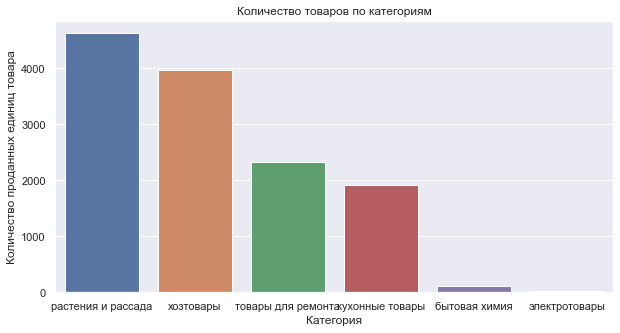

In [111]:
# Изобразим на графике
sns.set(rc={'figure.figsize':(10, 5)})

ax = sns.barplot(data=df.groupby('category')['quantity'].agg('sum').sort_values(ascending=False).reset_index(),
            x='category', y='quantity');

ax.set_title('Количество товаров по категориям')
ax.set_xlabel('Категория')
ax.set_ylabel('Количество проданных единиц товара')
plt.show();


In [28]:
# Добавление столбца с количеством категорий, товары из которых покупал пользователь

df['cat_by_user'] = df.groupby('customer_id')['category'].transform('nunique')

In [29]:
# Для Добавления столбца со средним временем между покупками создадим датафрейм отсортированный по id покупателя и дате

df_2 = df.drop_duplicates('order_id').sort_values(['customer_id', 'date'])

In [30]:
# Созжажит датафрейм, сгруппировав по пользователю и найдя разницу между покупками в днях

df_3 = df_2.groupby('customer_id').apply(
    lambda x: (x['date'] - x['date'].shift(1)).dt.days).reset_index()


In [31]:
# Закончим формирование датафрейма

df_3 = df_3.rename(columns={'date': 'time_between_purchases'})
df_3.index = df_3.level_1


In [32]:
# Объединим датафрейм с основным

df = df.join(df_3['time_between_purchases'])

In [33]:
# Посмотрим, есть ли нулевые значения в новом столбце

df['time_between_purchases'].isna().sum()

4463

В получившемся столбце образовались пропуски у клиентов, совершивших только одну покупку. Таковых большинство, поэтому адекватным значением вряд ли есть возможность заполнить все пропуски.

In [34]:
# Добавление столбца с временем с момента последней покупки (в днях)

today = pd.to_datetime('2020-02-01 00:00:00')  

oneday = pd.Timedelta(days=1)

df['last_purchase'] = (today - df.groupby('customer_id')['date'].transform('max')) / oneday

In [35]:
# Проверим

df.head(5)

,date,customer_id,order_id,product,quantity,price,year_month,full_price,order_price,order_quantity,category,cat_by_user,time_between_purchases,last_purchase
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0,1037.0,7,растения и рассада,1,NaN,488.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,194.0,1037.0,7,растения и рассада,1,NaN,488.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,112.0,1037.0,7,растения и рассада,1,NaN,488.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,179.0,1037.0,7,растения и рассада,1,NaN,488.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,112.0,1037.0,7,растения и рассада,1,NaN,488.0


In [36]:
# Посмотрим на рабочий датафрейм

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5542 entries, 0 to 7473
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5542 non-null   datetime64[ns]
 1   customer_id             5542 non-null   object        
 2   order_id                5542 non-null   int64         
 3   product                 5542 non-null   object        
 4   quantity                5542 non-null   int64         
 5   price                   5542 non-null   float64       
 6   year_month              5542 non-null   period[M]     
 7   full_price              5542 non-null   float64       
 8   order_price             5542 non-null   float64       
 9   order_quantity          5542 non-null   int64         
 10  category                5542 non-null   object        
 11  cat_by_user             5542 non-null   int64         
 12  time_between_purchases  1079 non-null   float64 

## Исследовательский анализ данных (EDA)

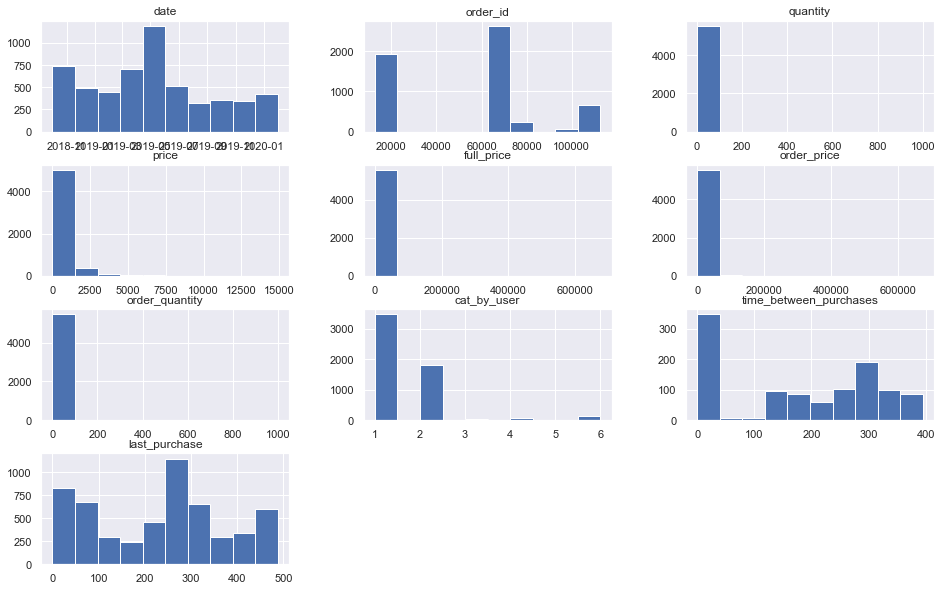

In [37]:
# Построим гистограмму

df.hist(figsize=(16,10));

In [38]:
# Время самого раннего заказа

df['date'].min()

Timestamp('2018-10-01 00:00:00')

In [39]:
# Время самого позднего заказа

df['date'].max()

Timestamp('2020-01-31 15:00:00')

В наличии данные с 1 октября 2018 года по конец января 2020. Пик продаж приходится на лето 2019 года.

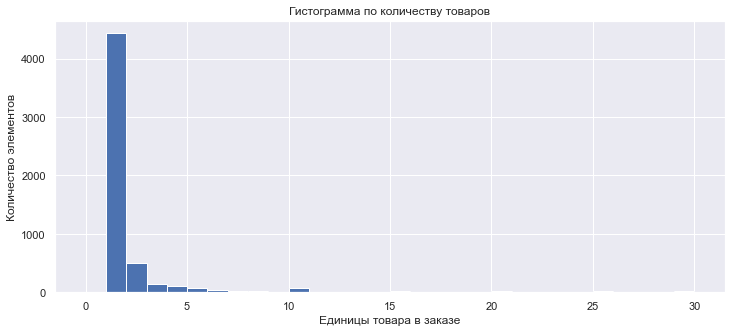

In [40]:
# Посмотрим поближе на гистограмму столбца quantity

sns.set(rc={'figure.figsize':(12, 5)})


ax = plt.hist(df['quantity'], range=[0, 30], bins=30)

plt.title('Гистограмма по количеству товаров')
plt.xlabel('Единицы товара в заказе')
plt.ylabel('Количество элементов')
plt.show();

Большая часть заказов имеет менее 6 одинаковых товаров.

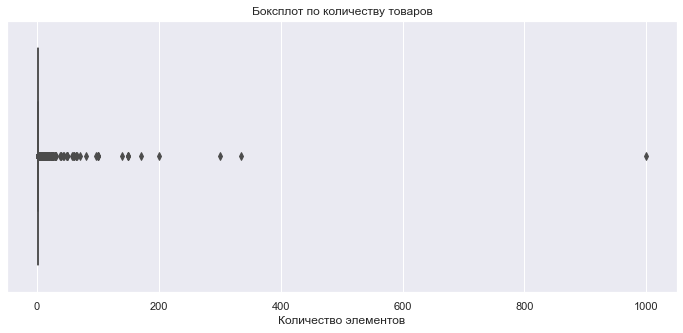

In [41]:
ax = sns.boxplot(df['quantity'])

plt.title('Боксплот по количеству товаров')
plt.xlabel('Количество элементов')
plt.show();

Существует странный выброс с 1000 позиций одинаковых товаров в заказе. Возможно, это ошибка, и данную строчку придется удалить при построении модели.

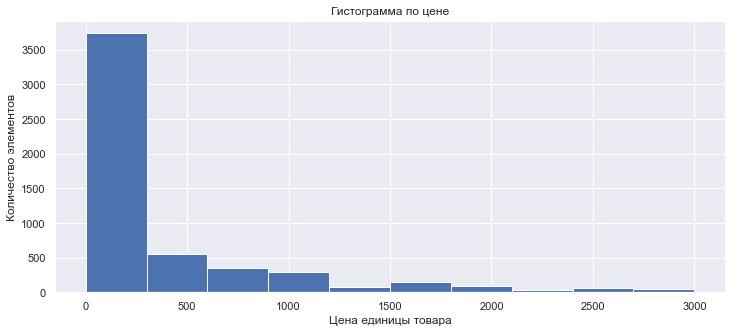

In [42]:
# Посмотрим поближе на гистограмму столбца price

ax = plt.hist(df['price'], range=[0, 3000])

plt.title('Гистограмма по цене')
plt.xlabel('Цена единицы товара')
plt.ylabel('Количество элементов')
plt.show();

Большая часть товаров имеет цену менее 2000 рублей.

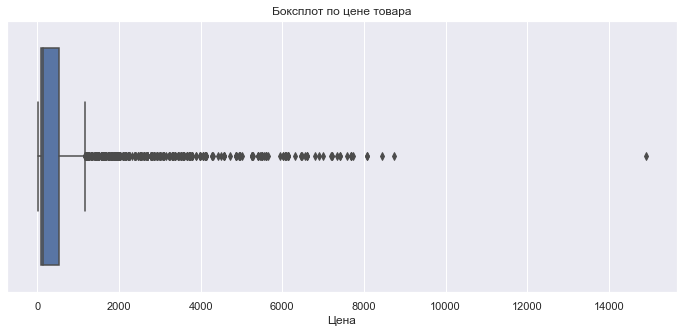

In [43]:
ax = sns.boxplot(df['price'])

plt.title('Боксплот по цене товара')
plt.xlabel('Цена')
plt.show();

Но существует дорогой товар стоимостью более 14000 рублей.

In [44]:
# Количество уникальных пользователей

df['customer_id'].nunique()

2413

In [45]:
# Количество уникальных заказов

df['order_id'].nunique()

3492

In [46]:
# Количество уникальных товаров

df['product'].nunique()

2332

In [47]:
# Посмотрим на количество товаров по заказам

df.groupby('order_id').agg({'quantity':'sum'}).sort_values('quantity', ascending=False).head(10)

,quantity
order_id,
71743,1000
71668,334
68611,300
71478,300
69289,200
68815,170
70841,150
68831,140
69156,101


Существует аномально большой заказ по количеству товаров.

In [48]:
# Посмотрим, как по категориям распределены покупатели

df.groupby('category')['customer_id'].nunique()

category
бытовая химия           48
кухонные товары        438
растения и рассада     943
товары для ремонта     208
хозтовары             1340
электротовары           24
Name: customer_id, dtype: int64

Самые популярные категории товаров - "растения и рассада" и "хозтовары", они же и самые объемные по ассортименту.

In [49]:
df.head(1)

,date,customer_id,order_id,product,quantity,price,year_month,full_price,order_price,order_quantity,category,cat_by_user,time_between_purchases,last_purchase
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0,1037.0,7,растения и рассада,1,NaN,488.0


In [50]:
# Создадим сводную таблицу по пользователям

customer_pivot = (
        df.groupby('customer_id').agg({'order_id':'count','full_price':'sum', 'quantity':'sum', 'cat_by_user':'max',
                                       'time_between_purchases':'mean', 'last_purchase':'max',
                                       'price':'mean', 'order_quantity':'mean'})
                 )

customer_pivot.columns = ['orders_total', 'revenue_total', 'quantity_total', 'categories',
                          'time_between_purchases', 'last_purchase', 'price_mean', 'quantity_mean']

In [51]:
# Добавим столбец со средним чеком

customer_pivot['bill_aver'] = round(customer_pivot['revenue_total'] / customer_pivot['orders_total'], 2)

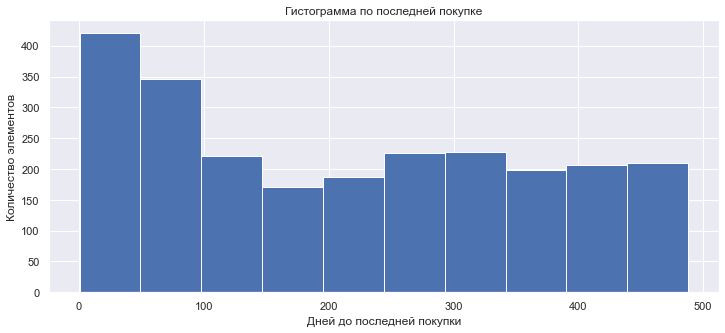

In [52]:
# Посмотрим поближе на гистограмму столбца last_purchase

ax = plt.hist(customer_pivot['last_purchase'])

plt.title('Гистограмма по последней покупке')
plt.xlabel('Дней до последней покупки')
plt.ylabel('Количество элементов')
plt.show();

Так как очень много клиентов делали покупки более 100 дней назад, можно говорить о плохой возвращаемости клиентов

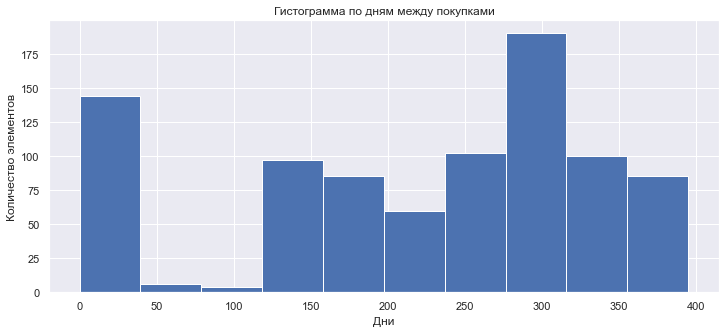

In [53]:
# Посмотрим поближе на гистограмму столбца time_between_purchases

ax = plt.hist(customer_pivot['time_between_purchases'])

plt.title('Гистограмма по дням между покупками')
plt.xlabel('Дни')
plt.ylabel('Количество элементов')
plt.show();

Из тех, кто делает повторную покупку, большинство делает ее только через 300 дней, т.е. примерно через год.

In [54]:
# Посмотрим на пользователей с самым большим количеством заказов

customer_pivot.sort_values('orders_total', ascending=False).head(5)

,orders_total,revenue_total,quantity_total,categories,time_between_purchases,last_purchase,price_mean,quantity_mean,bill_aver
customer_id,,,,,,,,,
c971fb21-d54c-4134-938f-16b62ee86d3b,143,159508.0,334,6,0.928000,331.500000,932.846154,3.111888,1115.44
d3b9ffea-d143-4747-8d59-74ab843d1ad6,51,2922.0,51,2,NaN,279.333333,57.294118,51.000000,57.29
4d93d3f6-8b24-403b-a74b-f5173e40d7db,45,57278.0,309,4,0.352941,464.416667,677.066667,14.822222,1272.84
760aa067-90c3-4794-b7a9-a8831197388b,36,4558.0,37,2,NaN,274.333333,121.916667,37.000000,126.61
2a0acc09-e343-4f92-b5c0-f598ef2b07d4,31,2280.0,60,2,NaN,282.125000,38.000000,60.000000,73.55


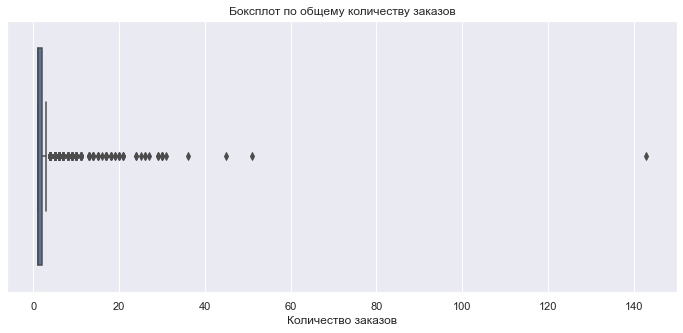

In [55]:
# Посмотрим боксплот столбца orders_total

sns.boxplot(customer_pivot['orders_total'])

plt.title('Боксплот по общему количеству заказов')
plt.xlabel('Количество заказов')
plt.show();

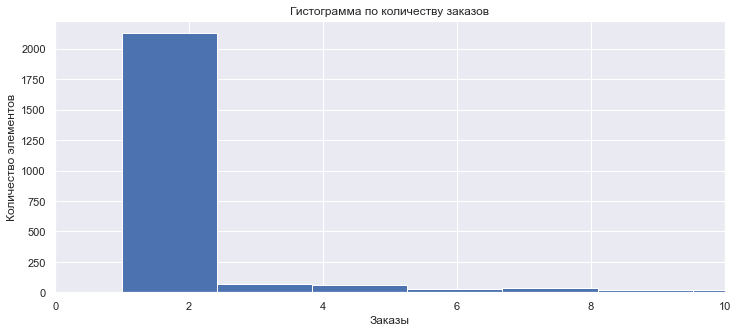

In [56]:
# Посмотрим поближе на гистограмму столбца orders_total

ax = plt.hist(customer_pivot['orders_total'], bins=100)

plt.xlim(0,10)
plt.title('Гистограмма по количеству заказов')
plt.xlabel('Заказы')
plt.ylabel('Количество элементов')
plt.show();

Большая часть пользователей делает не более двух заказов. Но существует пользователь с очень большим количеством заказов.

In [57]:
# Посмотрим на пользователей с самым большим количеством купленных товаров

customer_pivot.sort_values('quantity_total', ascending=False).head(5)

,orders_total,revenue_total,quantity_total,categories,time_between_purchases,last_purchase,price_mean,quantity_mean,bill_aver
customer_id,,,,,,,,,
312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1,675000.0,1000,1,NaN,227.375000,675.000000,1000.000000,675000.00
c971fb21-d54c-4134-938f-16b62ee86d3b,143,159508.0,334,6,0.928000,331.500000,932.846154,3.111888,1115.44
146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.0,334,1,NaN,234.708333,148.000000,334.000000,49432.00
4d93d3f6-8b24-403b-a74b-f5173e40d7db,45,57278.0,309,4,0.352941,464.416667,677.066667,14.822222,1272.84
5d189e88-d4d6-4eac-ab43-fa65a3c4d106,1,15300.0,300,1,NaN,256.125000,51.000000,300.000000,15300.00


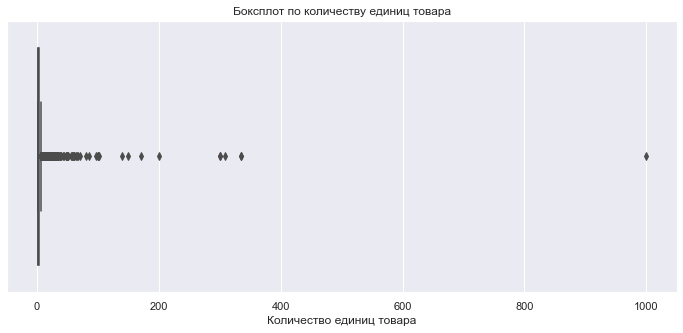

In [58]:
# Посмотрим поближе на боксплот столбца quantity_total

ax = sns.boxplot(customer_pivot['quantity_total'])

plt.title('Боксплот по количеству единиц товара')
plt.xlabel('Количество единиц товара')
plt.show();

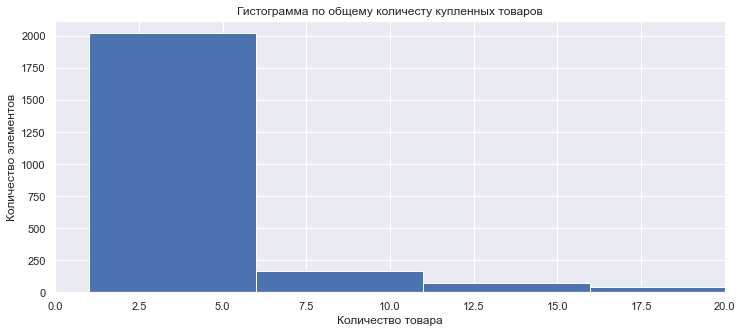

In [59]:
# Посмотрим поближе на гистограмму столбца quantity_total

ax = plt.hist(customer_pivot['quantity_total'], bins=200)

plt.xlim(0,20)
plt.title('Гистограмма по общему количесту купленных товаров')
plt.xlabel('Количество товара')
plt.ylabel('Количество элементов')
plt.show();

Большая часть покупателей берет суммарно не более 6 товаров

In [60]:
# Посмотрим, как по категориям распределены покупатели

customer_pivot['categories'].value_counts()

1    1846
2     555
3       6
4       4
5       1
6       1
Name: categories, dtype: int64

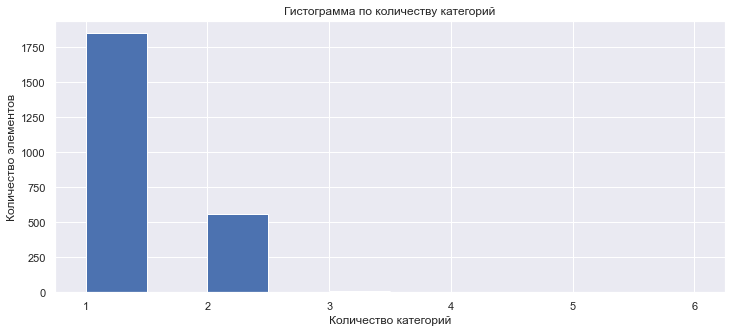

In [61]:
# Посмотрим поближе на гистограмму столбца quantity_total

ax = plt.hist(customer_pivot['categories'])

plt.title('Гистограмма по количеству категорий')
plt.xlabel('Количество категорий')
plt.ylabel('Количество элементов')
plt.show();

Подавляющее большинство покупателей берет товары из одной или двух категорий.

In [62]:
# Посмотрим на пользователей с самым большой суммарной выручкой

customer_pivot.sort_values('quantity_total', ascending=False).head(5)

,orders_total,revenue_total,quantity_total,categories,time_between_purchases,last_purchase,price_mean,quantity_mean,bill_aver
customer_id,,,,,,,,,
312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1,675000.0,1000,1,NaN,227.375000,675.000000,1000.000000,675000.00
c971fb21-d54c-4134-938f-16b62ee86d3b,143,159508.0,334,6,0.928000,331.500000,932.846154,3.111888,1115.44
146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.0,334,1,NaN,234.708333,148.000000,334.000000,49432.00
4d93d3f6-8b24-403b-a74b-f5173e40d7db,45,57278.0,309,4,0.352941,464.416667,677.066667,14.822222,1272.84
5d189e88-d4d6-4eac-ab43-fa65a3c4d106,1,15300.0,300,1,NaN,256.125000,51.000000,300.000000,15300.00


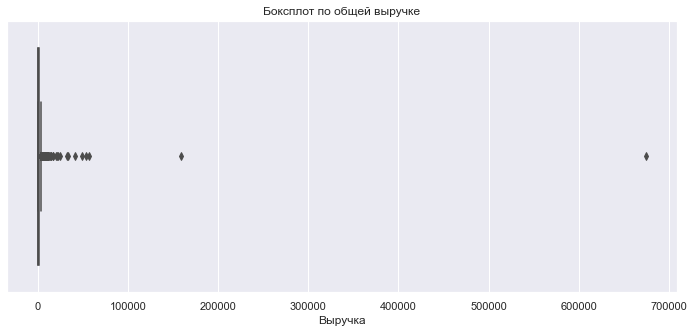

In [63]:
# Посмотрим поближе на боксплот столбца revenue_total

sns.boxplot(customer_pivot['revenue_total'])

plt.title('Боксплот по общей выручке')
plt.xlabel('Выручка')
plt.show();

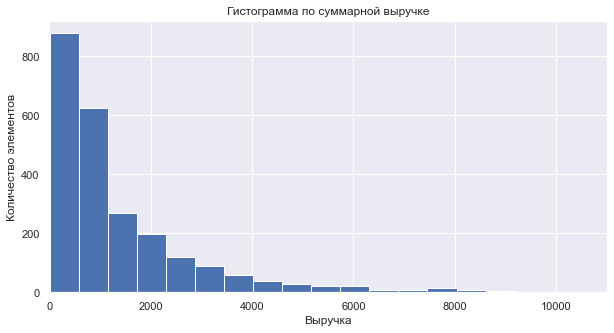

In [112]:
# Посмотрим поближе на гистограмму столбца revenue_total

ax = plt.hist(customer_pivot['revenue_total'], bins=100)

plt.xlim(0,11000)
plt.title('Гистограмма по суммарной выручке')
plt.xlabel('Выручка')
plt.ylabel('Количество элементов')
plt.show();

Суммарная выручка с покупателя редко превышает 8 тысяч.

In [65]:
# Посмотрим на пользователей с самым большим средним чеком

customer_pivot.sort_values('bill_aver', ascending=False).head(5)

,orders_total,revenue_total,quantity_total,categories,time_between_purchases,last_purchase,price_mean,quantity_mean,bill_aver
customer_id,,,,,,,,,
312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1,675000.0,1000,1,NaN,227.375000,675.0,1000.0,675000.0
146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.0,334,1,NaN,234.708333,148.0,334.0,49432.0
6987e6d6-a63a-4ce2-a2d0-f424092d235e,1,32718.0,57,1,NaN,406.333333,574.0,57.0,32718.0
58a4c3cc-504f-43ea-a74a-bae19e665552,2,53232.0,30,1,5.0,381.458333,1852.0,15.0,26616.0
1b2764ad-9151-4051-a46a-9b01b62e6335,1,24370.0,5,1,NaN,451.500000,4874.0,5.0,24370.0


Большая часть людей с большим средним чеком сделали по одному или два дорогому заказу.

## Сегментирование покупателей на основе истории их покупок

In [66]:
# Удалим аномальных пользователей

df = df[~ (df['customer_id'] == '312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6')]

df = df[~ (df['customer_id'] == 'c971fb21-d54c-4134-938f-16b62ee86d3b')]

customer_pivot.drop(index=['312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6','c971fb21-d54c-4134-938f-16b62ee86d3b'], inplace=True)

In [67]:
# Посмотрим на итоговый датафрейм

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5398 entries, 0 to 7473
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5398 non-null   datetime64[ns]
 1   customer_id             5398 non-null   object        
 2   order_id                5398 non-null   int64         
 3   product                 5398 non-null   object        
 4   quantity                5398 non-null   int64         
 5   price                   5398 non-null   float64       
 6   year_month              5398 non-null   period[M]     
 7   full_price              5398 non-null   float64       
 8   order_price             5398 non-null   float64       
 9   order_quantity          5398 non-null   int64         
 10  category                5398 non-null   object        
 11  cat_by_user             5398 non-null   int64         
 12  time_between_purchases  954 non-null    float64 

In [68]:
# Посмотрим на корреляцию признаков

customer_pivot.corr().style.background_gradient('coolwarm').format({'ratio': '{:,.2%}'.format}, precision=2)

,orders_total,revenue_total,quantity_total,categories,time_between_purchases,last_purchase,price_mean,quantity_mean,bill_aver
orders_total,1.00,0.20,0.30,0.23,-0.29,0.07,-0.13,0.23,-0.11
revenue_total,0.20,1.00,0.50,0.11,-0.12,0.01,0.44,0.23,0.78
quantity_total,0.30,0.50,1.00,0.03,-0.24,0.14,-0.13,0.65,0.40
categories,0.23,0.11,0.03,1.00,0.26,-0.38,-0.01,-0.04,-0.08
time_between_purchases,-0.29,-0.12,-0.24,0.26,1.00,-0.57,0.09,-0.38,-0.03
last_purchase,0.07,0.01,0.14,-0.38,-0.57,1.00,-0.08,0.11,0.05
price_mean,-0.13,0.44,-0.13,-0.01,0.09,-0.08,1.00,-0.10,0.53
quantity_mean,0.23,0.23,0.65,-0.04,-0.38,0.11,-0.10,1.00,0.24
bill_aver,-0.11,0.78,0.40,-0.08,-0.03,0.05,0.53,0.24,1.00


Существует сильная корреляция между признаками orders_total-revenue_total, а также revenue_total-quantity_total, revenue_total-bill_aver и last_purchase-last_purchase. Умеренная между orders_total-quantity_total, quantity_total-bill_aver и last_purchase-time_between_purchases.

In [69]:
# Создаем датафрейм с признаками

X = customer_pivot.reset_index().drop(columns=['customer_id', 'time_between_purchases', 
                                               'bill_aver', 'categories'], axis=1)

X.head(5)

,orders_total,revenue_total,quantity_total,last_purchase,price_mean,quantity_mean
0,4,555.0,4,107.666667,138.75,4.0
1,1,442.0,1,349.541667,442.00,1.0
2,1,914.0,2,109.041667,457.00,2.0
3,1,1649.0,1,369.291667,1649.00,1.0
4,1,2324.0,2,124.291667,1162.00,2.0


Всего для построения модели сегментации используем пять признаков:

1. Количество заказов
2. Суммарная выручка
3. Среднее количество товара в заказе
4. Средняя цена товара
5. Дни с последней покупки

In [70]:
# Стандартизируем признаки

sc = StandardScaler()

X_sc = sc.fit_transform(X)

In [71]:
# Создадим таблицу связок между признаками

linked = linkage(X_sc, method = 'ward') 

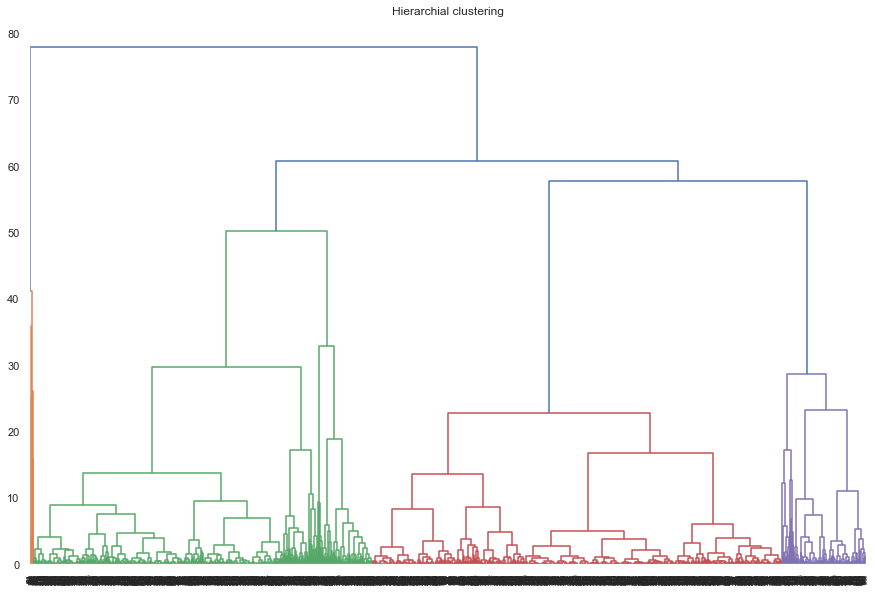

In [72]:
# И визуализируем ее как дендрограмму

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

Явно выделяется 4 кластера.

In [73]:
# Создадим модель k_means с числом кластеров 4

km = KMeans(n_clusters=4, random_state=5)

In [74]:
# Спрогнозируем кластеры

labels = km.fit_predict(X_sc)

In [75]:
# Посчитаем метрику silhouette_score для модели

print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.38


Модель выделила кластеры с перекрытием.

In [76]:
# Сохраним метки в датафрейм

customer_pivot['cluster_client'] = labels

In [77]:
# Посмотрим на количество пользователей в кластерах

customer_pivot.groupby('cluster_client').agg({'orders_total':'count'}).T

cluster_client,0,1,2,3
orders_total,1163,1074,7,167


Два кластеря - 0 и 1 - являются самыми объемными.

In [78]:
# выведем статистику по средним значениям наших признаков по кластеру

customer_pivot.groupby('cluster_client').agg('mean').T

cluster_client,0,1,2,3
orders_total,1.671539,2.880819,10.714286,1.706587
revenue_total,1111.277658,1120.494413,21374.285714,6712.733533
quantity_total,2.333620,7.451583,235.571429,3.664671
categories,1.379192,1.101490,1.428571,1.179641
time_between_purchases,246.981586,9.778646,0.352941,222.448370
last_purchase,90.781814,353.133147,364.172619,198.393962
price_mean,598.670510,397.891067,158.866667,3583.537387
quantity_mean,1.811149,8.116077,359.831746,3.193466
bill_aver,696.510739,737.094572,12134.441429,4446.280359


Кластеры 0 и 1 похожи - они самые объемные, у пользователей в данных кластерах похожи выручка с пользователя и средний чек. Однако, пользователи из класса 1 делали последнюю покупку около года назад, поэтому их можно считать ушедшими. У кластера 0 же последняя покупка была, в среднем, 90 дней назад, поэтому данный кластер можно считать активным. Однако, в отличие от кластера 1, пользователи кластера 0 покупают меньше товаров, делают меньше заказов и реже покупают, но выбирают товар в более дорогих категориях. Возможно, их следует простимулировать.

Кластер 2 характеризуется большим количеством заказов, позиций, большими выручкой и средним чеком. Они выбирают товар в дешевых категориях и них небольшой промежуток между заказами, однако они делали последний свой заказ, в среднем, год назад. Данный кластер объединяет оптовиков. 

Кластер 3 характеризуется небольшим заказов и товаров, но относительно высокими выручкой и средним чеком вследствие выбора дорогих товаров. Однако, последнюю покупку они совершали порядка 200 дней назад.

In [79]:
# Зададим функцию для отрисовки графиков для попарных сочетаний признаков с разметкой по кластерам

def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

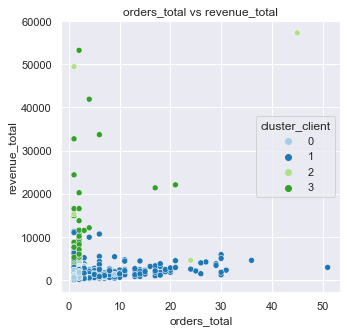

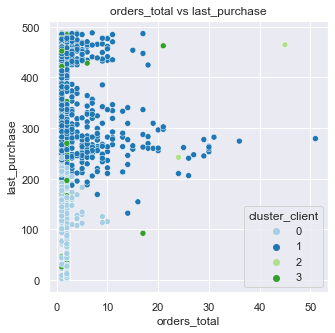

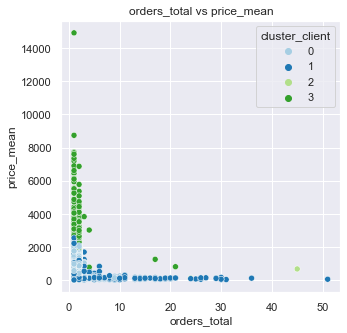

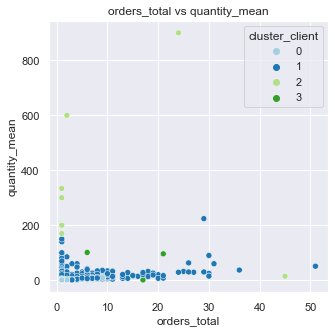

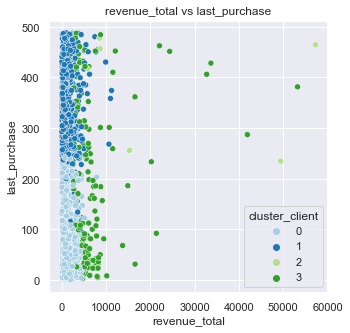

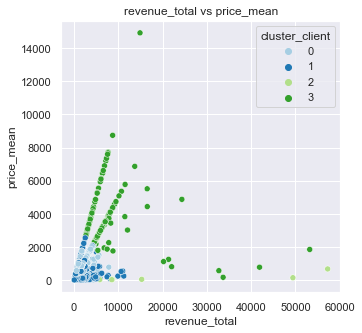

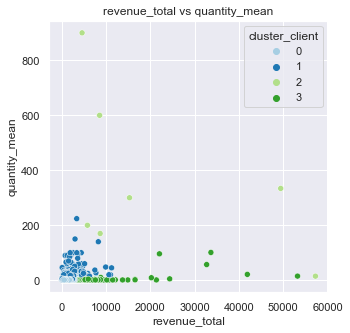

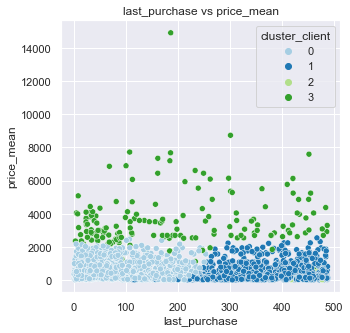

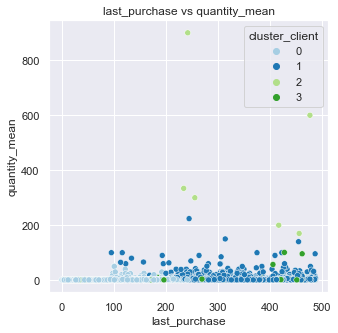

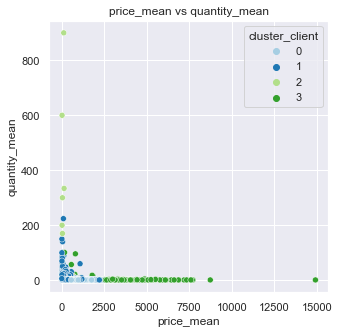

In [80]:
# Отрисуем графики

col_pairs = list(itertools.combinations(customer_pivot.reset_index().drop(columns=['customer_id', 
                                               'time_between_purchases', 
                                               'categories', 'quantity_total', 'cluster_client', 'bill_aver']
                                                                          , axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(customer_pivot, pair[0], pair[1], 'cluster_client')

Судя по графикам, можно сказать, что средние пользователи, которые сделали последнюю покупки 200 и более дней назад (кластер 1), чем средние пользователи, у которых последняя покупка было до 200 дней (кластер 0). Однако, самую большую прибыль приносят либо оптовики (кластер 2), делающие много заказов, либо покупател выбирающие дорогие товары (кластер 3), но делающие мало заказов.

## Проверка статистических гипотез

Проверка гипотез будет производиться по преимущество с помощью t-теста. Требованием к данному тесту является нормальность распределения выборочных средних, что для больших выборок, какие имеем в наличии и мы в кластерах 0, 1 и 3, обеспечивается ЦПТ. Для кластера 2 посмотрим на распределение средних.

In [81]:
customer_pivot.reset_index().groupby('cluster_client')['customer_id'].agg('count')

cluster_client
0    1163
1    1074
2       7
3     167
Name: customer_id, dtype: int64

### Проверка кластера 2

In [82]:
# Посмотрим, сколько разных выборок размера 4 можно взять из кластера размера 7

math.factorial(7) / (math.factorial(4) * math.factorial(3))

35.0

In [113]:
# Возьмем 35 выборок размера 4 из кластера

bills_cl_2 = [customer_pivot.query('cluster_client == 2')['bill_aver'].sample(4).mean() for _ in range(35)]

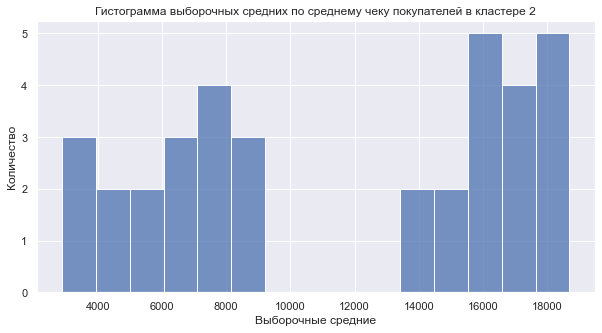

In [114]:
# Отрисуем на гистограмме 

ax = sns.histplot(bills_cl_2, bins=15)

ax.set_title('Гистограмма выборочных средних по среднему чеку покупателей в кластере 2')
ax.set_xlabel('Выборочные средние')
ax.set_ylabel('Количество')
plt.show();

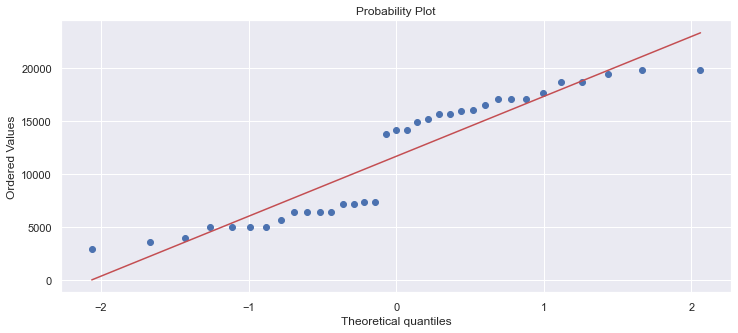

In [85]:
# Отрисуем qq-плот

import pylab 
import scipy.stats as stats

stats.probplot(bills_cl_2, dist="norm", plot=pylab)
pylab.show()


In [115]:
# Возьмем 35 выборок размера 4 из кластера

orders_cl_2 = [customer_pivot.query('cluster_client == 2')['orders_total'].sample(4).mean() for _ in range(35)]

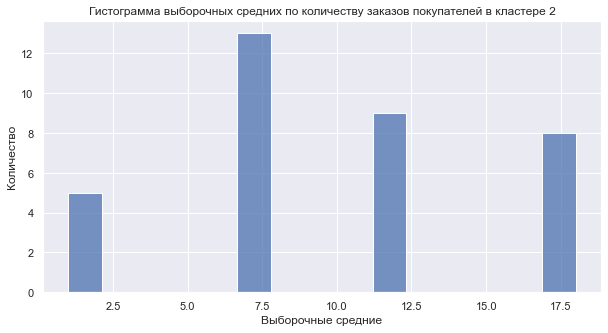

In [116]:
# Отрисуем на гистограмме 

ax = sns.histplot(orders_cl_2, bins=15)

ax.set_title('Гистограмма выборочных средних по количеству заказов покупателей в кластере 2')
ax.set_xlabel('Выборочные средние')
ax.set_ylabel('Количество')
plt.show();

In [117]:
# Проверим на нормальность с помощью теста Шапиро-Уилка

stats.shapiro(bills_cl_2)

ShapiroResult(statistic=0.8684267997741699, pvalue=0.0006216797628439963)

In [118]:
# Проверим на нормальность с помощью теста Шапиро-Уилка

stats.shapiro(orders_cl_2)

ShapiroResult(statistic=0.8848571181297302, pvalue=0.0015873325755819678)

Нельля назвать данные распределения нормальными, поэтому для проверки гипотез с данным кластером будет использоваться непараметрический тест Манна-Уитни.

### Гипотеза первая

**H0: Нет стат. значимых различий между количеством заказов**

**H1: Есть стат. значимые различия между количеством заказов**

In [89]:
# Проведем для всех кластеров t-тест

alpha = 0.05  # критический уровень статистической значимости

alhpa_corr = 1 - (1 - 0.05)**(1/4) # скорректированный alpha по методу Шидака

A = customer_pivot.query('cluster_client == 0')['orders_total']

B = customer_pivot.query('cluster_client == 1')['orders_total']

C = customer_pivot.query('cluster_client == 2')['orders_total']

D = customer_pivot.query('cluster_client == 3')['orders_total']

results_AB = st.ttest_ind(A, B)


results_AD = st.ttest_ind(A, D)


results_BD = st.ttest_ind(B, D)

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп А и D: ', results_AD.pvalue)
print('p-значение для сравнения групп B и D: ', results_BD.pvalue)

p-значение для сравнения групп А и B:  1.2142946650293814e-18
p-значение для сравнения групп А и D:  0.6582765501645755
p-значение для сравнения групп B и D:  0.0011474985971349175


In [90]:
if results_AB.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )


if results_AD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и D'
    ) 
    

if results_BD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп B и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и D'
    )



Отвергаем нулевую гипотезу для сравнения групп А и B
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и D
Отвергаем нулевую гипотезу для сравнения групп B и D


Существует стат. значимое различие в среднем чеке между всеми группами, кроме A и D - 0 и 3 кластерами.

In [91]:
# Проведем для всех кластеров U-тест

alpha = 0.05  # критический уровень статистической значимости

alhpa_corr = 1 - (1 - 0.05)**(1/4) # скорректированный alpha по методу Шидака

A = customer_pivot.query('cluster_client == 0')['orders_total']

B = customer_pivot.query('cluster_client == 1')['orders_total']

C = customer_pivot.query('cluster_client == 2')['orders_total']

D = customer_pivot.query('cluster_client == 3')['orders_total']

results_AB = st.mannwhitneyu(A, B)

results_AC = st.mannwhitneyu(A, C)

results_AD = st.mannwhitneyu(A, D)

results_BC = st.mannwhitneyu(B, C)

results_BD = st.mannwhitneyu(B, D)

results_CD = st.mannwhitneyu(C, D)

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп A и C: ', results_AC.pvalue)
print('p-значение для сравнения групп А и D: ', results_AD.pvalue)
print('p-значение для сравнения групп B и C: ', results_BC.pvalue)
print('p-значение для сравнения групп B и D: ', results_BD.pvalue)
print('p-значение для сравнения групп C и D: ', results_CD.pvalue)


p-значение для сравнения групп А и B:  2.9282915142082783e-08
p-значение для сравнения групп A и C:  0.9033093956356628
p-значение для сравнения групп А и D:  6.383323799910714e-05
p-значение для сравнения групп B и C:  0.47511298757311393
p-значение для сравнения групп B и D:  0.909862028662828
p-значение для сравнения групп C и D:  0.6028221234460873


In [92]:
if results_AB.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_AC.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп A и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп A и C'
    )

if results_AD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и D'
    ) 
    
if results_BC.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_BD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп B и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и D'
    )

if results_CD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп C и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D'
    ) 


Отвергаем нулевую гипотезу для сравнения групп А и B
Не получилось отвергнуть нулевую гипотезу для сравнения групп A и C
Отвергаем нулевую гипотезу для сравнения групп А и D
Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C
Не получилось отвергнуть нулевую гипотезу для сравнения групп B и D
Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D


U-тест, в отличие от t-test, проверяет, взяты ли выборки из одного распределения (из одной ген.совокупности), а не равенство средних, т.е. имеет иную априорную нулевую гипотезу, поэтому его результаты различаются с t-тестом.

U-тест нашел стат. значимое различие только для кластеров A-В и А-D.

### Гипотеза вторая

**H0: Нет стат. значимых различий в средних чеках между сегмантами**

**H1: Есть стат. значимые различия  в средних чеках между сегмантами**

In [93]:
# Проведем для всех кластеров t-тест

alpha = 0.05  # критический уровень статистической значимости

alhpa_corr = 1 - (1 - 0.05)**(1/4)

A = customer_pivot.query('cluster_client == 0')['bill_aver']

B = customer_pivot.query('cluster_client == 1')['bill_aver']

C = customer_pivot.query('cluster_client == 2')['bill_aver']

D = customer_pivot.query('cluster_client == 3')['bill_aver']

results_AB = st.ttest_ind(A, B)

results_AD = st.ttest_ind(A, D)

results_BD = st.ttest_ind(B, D)

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп А и D: ', results_AD.pvalue)
print('p-значение для сравнения групп B и D: ', results_BD.pvalue)

p-значение для сравнения групп А и B:  0.2624042246636712
p-значение для сравнения групп А и D:  7.006049233379233e-153
p-значение для сравнения групп B и D:  3.6774135703942185e-122


In [94]:
if results_AB.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_AD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и D'
    ) 

if results_BD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп B и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и D'
    )



Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B
Отвергаем нулевую гипотезу для сравнения групп А и D
Отвергаем нулевую гипотезу для сравнения групп B и D


Существует стат. значимое различие в среднем чеке между всеми группами, кроме A и B - 0 и 1 кластерам, которые различаются, в целом, как ушедшие и активные.

In [95]:
# Проведем для всех кластеров U-тест

alpha = 0.05  # критический уровень статистической значимости

alhpa_corr = 1 - (1 - 0.05)**(1/4)

A = customer_pivot.query('cluster_client == 0')['bill_aver']

B = customer_pivot.query('cluster_client == 1')['bill_aver']

C = customer_pivot.query('cluster_client == 2')['bill_aver']

D = customer_pivot.query('cluster_client == 3')['bill_aver']

results_AB = st.mannwhitneyu(A, B)

results_AC = st.mannwhitneyu(A, C)

results_AD = st.mannwhitneyu(A, D)

results_BC = st.mannwhitneyu(B, C)

results_BD = st.mannwhitneyu(B, D)

results_CD = st.mannwhitneyu(C, D)

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп A и C: ', results_AC.pvalue)
print('p-значение для сравнения групп А и D: ', results_AD.pvalue)
print('p-значение для сравнения групп B и C: ', results_BC.pvalue)
print('p-значение для сравнения групп B и D: ', results_BD.pvalue)
print('p-значение для сравнения групп C и D: ', results_CD.pvalue)


p-значение для сравнения групп А и B:  0.0013627777399807873
p-значение для сравнения групп A и C:  0.0008650105654056475
p-значение для сравнения групп А и D:  6.25856595919688e-93
p-значение для сравнения групп B и C:  0.0006438707034580784
p-значение для сравнения групп B и D:  1.4053301403228815e-86
p-значение для сравнения групп C и D:  0.2035167371598442


In [96]:
if results_AB.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_AC.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп A и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп A и C'
    )

if results_AD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп А и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и D'
    ) 
    
if results_BC.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_BD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп B и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и D'
    )

if results_CD.pvalue < alhpa_corr:
    print('Отвергаем нулевую гипотезу для сравнения групп C и D')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D'
    ) 


Отвергаем нулевую гипотезу для сравнения групп А и B
Отвергаем нулевую гипотезу для сравнения групп A и C
Отвергаем нулевую гипотезу для сравнения групп А и D
Отвергаем нулевую гипотезу для сравнения групп B и C
Отвергаем нулевую гипотезу для сравнения групп B и D
Не получилось отвергнуть нулевую гипотезу для сравнения групп C и D


U-тест показал различие между всеми кластерами, кроме C и D.

Можно сказать, что кластеры выделены удачно

## Исследование кластеров

In [97]:
# Добавим кластер клиента к итоговому датафрейму

df = df.merge(customer_pivot['cluster_client'], on='customer_id')

In [98]:
# Проверим

df.head(1)

,date,customer_id,order_id,product,quantity,price,year_month,full_price,order_price,order_quantity,category,cat_by_user,time_between_purchases,last_purchase,cluster_client
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0,1037.0,7,растения и рассада,1,NaN,488.0,1


In [99]:
# Построим сводную таблицу по кластерам и категориям товаров

df.pivot_table(index='cluster_client', columns='category', values='quantity', aggfunc='sum')

category,бытовая химия,кухонные товары,растения и рассада,товары для ремонта,хозтовары,электротовары
cluster_client,,,,,,
0,44.0,313.0,889.0,261.0,1188.0,19.0
1,75.0,1385.0,3635.0,994.0,1904.0,10.0
2,NaN,28.0,49.0,1052.0,520.0,NaN
3,1.0,182.0,49.0,26.0,351.0,3.0


Пользователи кластера 0 с высокой выручкой больше всего покупали в категориях "хозтовары" и "товары для ремонта", кластер 3 с высоким количеством заказов покупали преимущественно в категории "растения и рассада".

Пользователи похожих кластеров 1 и 2 покупают во всех категориях, но предпочитают четыре категории: "кухонные товары", "растения и рассада", "товары для ремонта" и "хозтовары", однако пользователи из кластера 2 купили больше товара. 

In [100]:
# Посмотрим на таблице во времени

pd.set_option('display.max_columns', None)

season_pivot = (
df.pivot_table(index=['year_month', 'cluster_client'], columns='category', values='quantity', aggfunc='sum')
)

season_pivot.T.style.background_gradient('coolwarm')

In [102]:
# Создадим сводную таблицу по времени

season_pivot_1 = (
df.pivot_table(index=['year_month', 'cluster_client', 'category'], values='quantity', aggfunc='sum').reset_index()
)

In [103]:
# Изменим формат 'year_month', сделав его приемлемым для графиков

season_pivot_1 = season_pivot_1.reset_index().set_index('year_month')

season_pivot_1.index=season_pivot_1.index.to_series().astype(str)

season_pivot_1 = season_pivot_1.reset_index()

season_pivot_1['year_month'] = pd.to_datetime(season_pivot_1['year_month'])

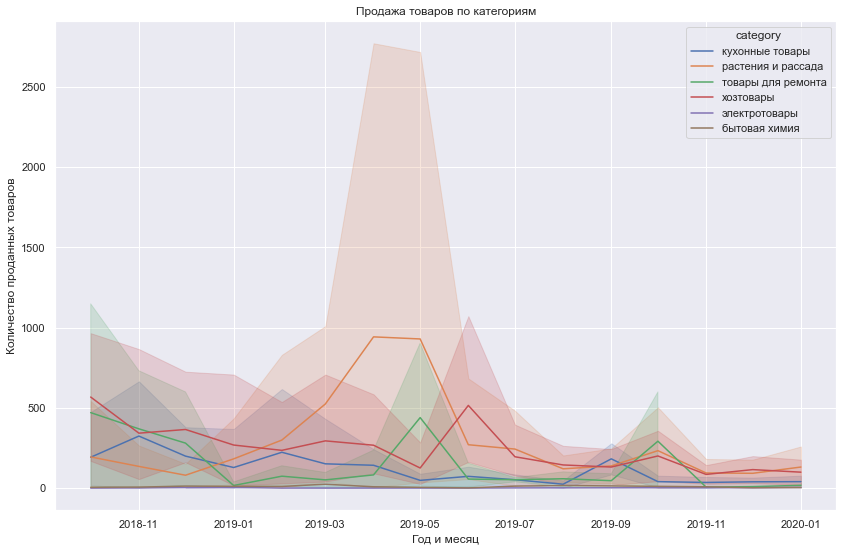

In [104]:
sns.set(rc={'figure.figsize':(14, 9)})

ax = sns.lineplot(data=season_pivot_1, x='year_month', y='quantity', estimator='sum', hue='category')
ax.set_title(f'Продажа товаров по категориям')
ax.set_xlabel('Год и месяц')
ax.set_ylabel('Количество проданных товаров')
plt.show();

sns.set(rc={'figure.figsize':(12, 5)})


Ярче всего заметен сезонный фактор в категории "растения и рассада" - устойчивый пик данной категории приходится на весну-начало лета. Весной и ранним летом также существуют пики продаж в категориях "товары для ремонта" и "хозтовары". У "товаров для ремонта" также существует пик в октябре, у "кухонных товаров" - в сентябре после продолжительного падения продаж практически до нуля. О "бытовой химии" и "электротоварах" тяжело что-то сказать из-за маленького количества продаж в данных категориях. Самыми стабильными по продажам являются категории "растения и рассада" и "хозтовары".

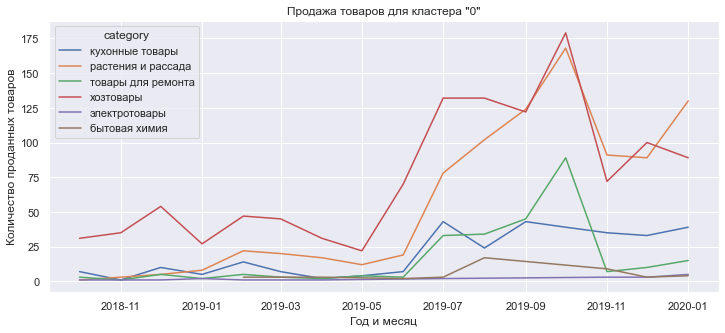

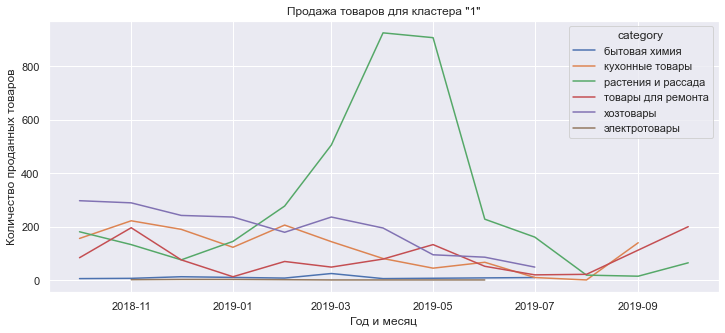

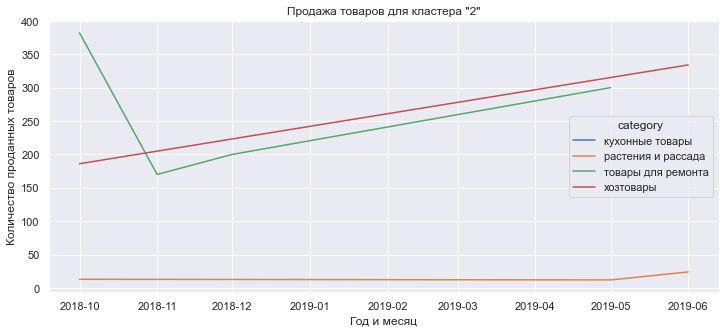

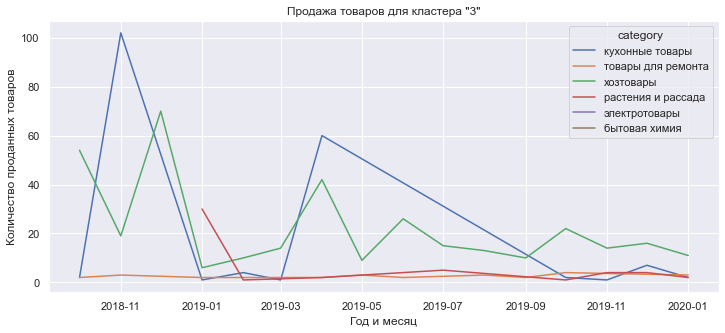

In [105]:
for i in range(0, 4):
    ax = sns.lineplot(data=season_pivot_1.query('cluster_client == @i'), 
                      x='year_month', y='quantity', estimator='sum', hue='category')
    ax.set_title(f'Продажа товаров для кластера "{i}"')
    ax.set_xlabel('Год и месяц')
    ax.set_ylabel('Количество проданных товаров')
    plt.show();


Кластер 0 начал активно покупать осенью 2019 года в категориях "растения и рассада", "хозтовары", "товары для ремонта", но покупатели совершают покупки и в других категориях. 

Кластер 1 показал огромный пик продаж в дачный период в категориях "растения и рассада". Возможно, в 2020 году следует ждать подобного всплеска у кластера 0, если кластер 1 перестанет совершать покупки.

Оптовики предпочитают покупать в категориях "хозтовары" и "товары для ремонта".

"Дорогой" кластер три предпочитает покупать "хозтовары", однако дает пики продаж и в "кухонных товарах".

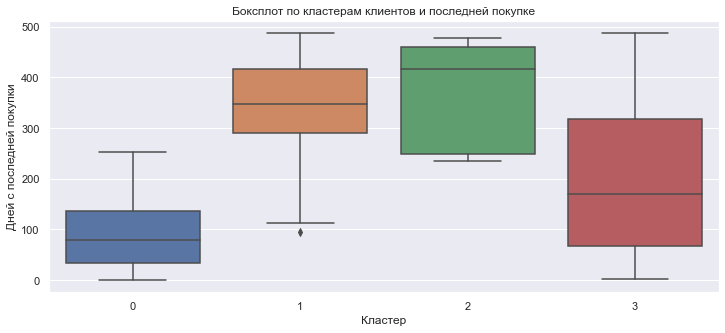

In [106]:
# Пострим боксплот для кластерам и дней с последней покупки

ax = sns.boxplot(data=customer_pivot, x='cluster_client', y='last_purchase');

ax.set_title('Боксплот по кластерам клиентов и последней покупке')
ax.set_xlabel('Кластер')
ax.set_ylabel('Дней с последней покупки')
plt.show();


По боксплоту видно, что пользователи лишь из двух кластеров - 1-го и 3-го - продолжают пользоваться услугами магазина. Заметно перекрытие кластеров 0 и 1 вследствие похожести пользователей из данных кластеров.

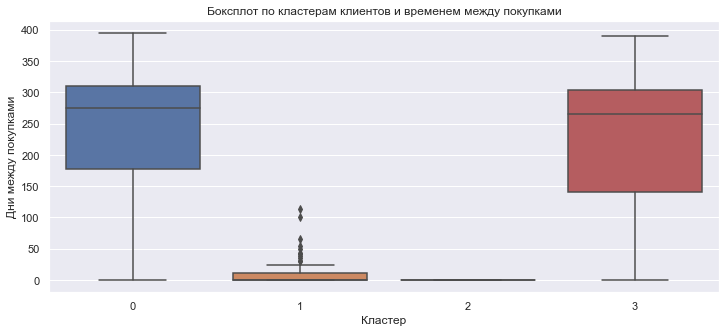

In [107]:
# Пострим боксплот для категорий и днями между покупками
 
ax = sns.boxplot(data=customer_pivot, x='cluster_client', y='time_between_purchases');

ax.set_title('Боксплот по кластерам клиентов и временем между покупками')
ax.set_xlabel('Кластер')
ax.set_ylabel('Дни между покупками')
plt.show();


К сожалению, активные кластеры 0 и 3 имеет и большое медианное время между покупками. Если не стимулировать пользователей из данных кластеров к повторным покупкам, они могут также уходить.

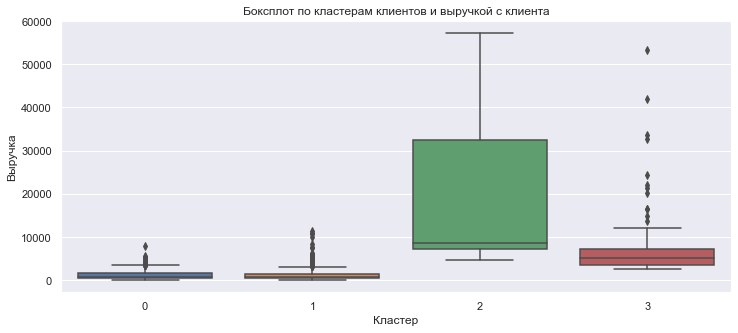

In [108]:
# Пострим боксплот для категорий и выручке

ax = sns.boxplot(data=customer_pivot, x='cluster_client', y='revenue_total');

ax.set_title('Боксплот по кластерам клиентов и выручкой с клиента')
ax.set_xlabel('Кластер')
ax.set_ylabel('Выручка')
plt.show();


Показывает высокую выручку кластер оптовиков - 2, но пользователи из него уже не возвращаются долгое время, а также кластер 3, показывающий дорогие выбросы.

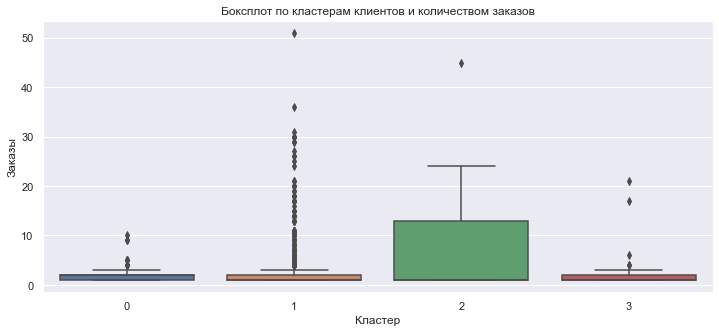

In [109]:
# Пострим боксплот для категорий и количеством заказов

ax = sns.boxplot(data=customer_pivot, x='cluster_client', y='orders_total');

ax.set_title('Боксплот по кластерам клиентов и количеством заказов')
ax.set_xlabel('Кластер')
ax.set_ylabel('Заказы')
plt.show();


По количеству заказов выделается кластер 1, который был очень активен в дачный период.

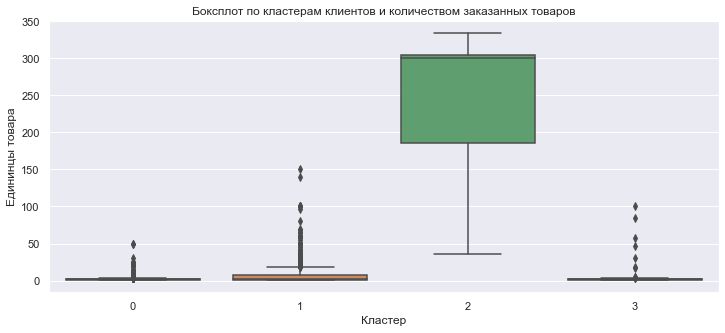

In [110]:
# Пострим боксплот для категорий и количеством заказанных товаров

ax = sns.boxplot(data=customer_pivot, x='cluster_client', y='quantity_total');

ax.set_title('Боксплот по кластерам клиентов и количеством заказанных товаров')
ax.set_xlabel('Кластер')
ax.set_ylabel('Едининцы товара')
plt.show();


Больше всего единиц товара заказал кластер кластер оптовиков, принесший больше всего денег.

## Вывод

Как материал для анализа был датафрейм с заказами от интернет-магазина. В ходе предобработки было обнаружено, что существуют неявные дубликаты, а также одинаковые по id заказы, но принадлежащие разным пользователям. Также были выявлено два аномальных пользователя с большим количеством заказов и большой выручкой. Первичный датафрейм содержал 7474 строк, финальный - 5398.

Исследовательский анализ данных выявил, что всего в базе 2413 пользователя, которые совершили 3492 заказа. Большая часть пользователей заказывает не более 6 единиц одинакового товара, делает не более двух заказов и не более чем в двух категориях. Суммарная выручка с пользователя редко превышает 8 тысяч.

Для кластеризации клиентов были использованы признаки "количество заказов", "суммарная выручка", "дни с последней покупки",
"средний чек". В качестве показателя количества кластеров была использована иерархическая кластеризация, визуализированная в виде дендрограммы. Метод показал 4 кластера. Кластеризация была проведена с помощью модели k-means, который выделил 4 кластера со следующим количеством покупателей 0 - 1163,	1 - 1074,	2 - 7,	3 - 167. Правильность выделения кластеров была подтвреждена проверкой двух статистических гипотез: 

1.

- H0: Нет стат. значимых различий в средних чеках между сегмантами

- H1: Есть стат. значимые различия  в средних чеках между сегмантами

    - t-test показал значимые различия между всеми кластерами, кроме 0-1 (проверены кластеры 0, 1 и 3)
    - U-test показал значимые различия между всеми кластерами 0-2 и 0-4  (проверены все кластеры)



2.

- H0: Нет стат. значимых различий в количестве заказов между сегмантами

- H1: Есть стат. значимые различия в количестве заказов между сегмантами

    - t-test показал значимые различия между всеми кластерами, кроме 0 и 3 (проверены кластеры 0, 1 и 3)
    - U-test показал значимые различия между всеми кластерами, кроме 2 и 3 (проверены все кластеры) 




Ярче всего заметен сезонный фактор в категории "растения и рассада" - устойчивый пик данной категории приходится на весну-начало лета. Весной и ранним летом также существуют пики продаж в категориях "товары для ремонта" и "хозтовары". У "товаров для ремонта" также существует пик в октябре, у "кухонных товаров" - в сентябре после продолжительного падения продаж практически до нуля. О "бытовой химии" и "электротоварах" тяжело что-то сказать из-за маленького количества продаж в данных категориях. Самыми стабильными по продажам являются категории "растения и рассада" и "хозтовары".

Кластеры имеют следующие характеристики:

Кластеры 0 и 1 похожи - они самые объемные, у пользователей в данных кластерах похожи выручка с пользователя и средний чек. Однако, пользователи из класса 1 делали последнюю покупку около года назад, поэтому их можно считать ушедшими. У кластера 0 же последняя покупка была, в среднем, 90 дней назад, поэтому данный кластер можно считать активным. Однако, в отличие от кластера 1, пользователи кластера 0 покупают меньше товаров, делают меньше заказов и реже покупают, но выбирают более дорогие товары. Возможно, их следует простимулировать в покупках. Кластера 0 покупает почти во всех категориях, были пики продаж в категориях "растения и рассада", "хозтовары", "товары для ремонта" осенью 2019 года. Возможно, от активного кластера следует ждать всплеска продаж в дачный период - весной-начале лета.

Кластер 2 характеризуется большим количеством заказов, позиций, большими выручкой и средним чеком. Они выбирают товар в дешевых категориях и них небольшой промежуток между заказами, однако они делали последний свой заказ, в среднем, год назад. Данный кластер объединяет оптовиков. К сожалению, оптовики уже давно ничего не заказывали. Оптовики предпочитают покупать в категориях "хозтовары" и "товары для ремонта".

Кластер 3 характеризуется небольшим заказов и товаров, но относительно высокими выручкой и средним чеком вследствие выбора дорогих товаров. Многие пользователи из данной категории продолжают быть активными, поэтому можно им делать специальные предложения. "Дорогой" кластер три предпочитает покупать "хозтовары", однако дает пики продаж и в "кухонных товарах".

